# Calculating mortar projection matrices

Author(s): Jukka Aho

**Abstract**: Evaluate mortar projection matrices in 2d and 3d

In [54]:
using JuliaFEM
using JuliaFEM: Seg2, Basis, Field, FieldSet, dinterpolate, interpolate, get_connectivity
using PyPlot
using ForwardDiff

Create some test boundaries:

In [55]:
function rlinspace(X1, X2, R, n, p0)
    fx(ϕ, xc) = R*cos(ϕ) + xc
    fy(ϕ, yc) = R*sin(ϕ) + yc
    function F(p)
        ϕ1, ϕ2, xc, yc = p
        return [
            fx(ϕ1, xc) - X1[1]
            fy(ϕ1, yc) - X1[2]
            fx(ϕ2, xc) - X2[1]
            fy(ϕ2, yc) - X2[2]
        ]
    end
    J = ForwardDiff.jacobian(F)
    p = copy(p0)
    for i=1:10
        dp = -J(p) \ F(p)
        p += dp
        if norm(dp) < 1.0e-9
            println("Converged. p = $p")
            break
        end
    end
    ϕ1, ϕ2, xc, yc = p
    ϕ = linspace(ϕ2, ϕ1, n)
    return fx(ϕ, xc), fy(ϕ, yc)
end

rlinspace (generic function with 1 method)

In [56]:
function FEM.interpolate(basis::Basis, field::Field, xis::Array{Vector,1})
    [FEM.interpolate(basis, field, xi) for xi in xis]
end
#FEM.interpolate(Γ₁[1], "geometry", Vector[[-1.0], [1.0]], 0.0)

interpolate (generic function with 11 methods)

Converged. p = [4.2905787641613236,5.624156522861784,0.04706336239279979,6.561746550428803]

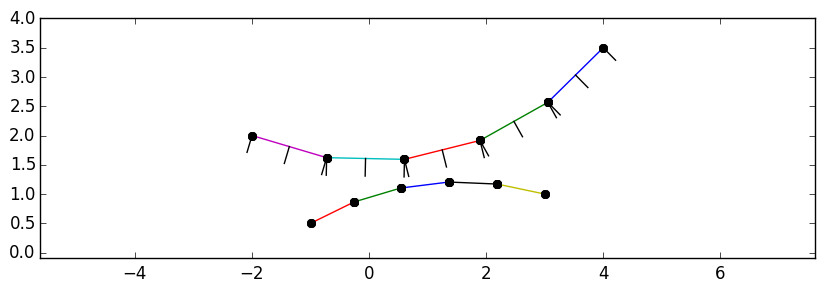

(-0.1,4.0)


Converged. p = [2.110067133637596,1.2802355090457196,1.5675520985912952,-3.7904167887303712]


In [78]:
srand(42)

nsl = 6
nm = 5

ϕ11 = 5.4
ϕ12 = 4.6
R1 = 5
xc1 = -0.8
yc1 = 9.9
X1 = [-2.0, 2.0]
X2 = [4.0, 3.5]
x1, y1 = rlinspace(X1, X2, R1, nsl, [ϕ11, ϕ12, xc1, yc1])

ϕ11 = 2.2
ϕ12 = 1.1
R1 = 5
xc1 = 1.9
yc1 = -4.1
X1 = [-1.0, 0.5]
X2 = [3.0, 1.0]
x2, y2 = rlinspace(X1, X2, R1, nsl, [ϕ11, ϕ12, xc1, yc1])

#x1 = linspace(0, 3, nsl) + rand(nsl)*0.1
#y1 = 0.5*rand(nsl)
#x2 = linspace(0, 3, nm) + rand(nm)*0.1 + 0.4
#y2 = 0.5*rand(nm) + 0.5

"""
Calculate element local normal field
"""
function calculate_normals!(element::Seg2, time, field_name="normal")
    normal_fieldset = FieldSet(field_name)
    normal_field = Field(time, Vector[])
    tangent(xi) = dinterpolate(element, "geometry", xi, time)
    for xi in Vector[[-1.0], [1.0]]
        t = tangent(xi)
        n = [-t[2], t[1]]
        push!(normal_field, n/norm(n))
    end
    push!(normal_fieldset, normal_field)
    push!(element, normal_fieldset)
end

function create_elements(X, sid=0)
    Γ = []
    nnodes = size(X, 2)
    nelements = nnodes-1
    for i=1:nelements
        con = sid+[i, i+1]
        el = Seg2(con)
        push!(el, FieldSet("geometry", [Field(0.0, Vector[X[:, i], X[:, i+1]])]))
        push!(Γ, el)
    end
    return Γ
end

function plot_element(el; plot_with_normal=false)
    # create a array of vectors
    xis = linspace([-1.0], [1.0], 3)
    time = 0.0
    coords = interpolate(el, "geometry", xis, time)
    ncoords = interpolate(el, "geometry", xis, time)
    normals = interpolate(el, "normal", xis, time)
    xs = [X[1] for X in coords]
    ys = [X[2] for X in coords]
    plot(xs, ys, "-")
    plot([xs[1], xs[end]], [ys[1], ys[end]], "ko")
    plot([xs[1], xs[end]], [ys[1], ys[end]], "ko")
    if plot_with_normal
        for i=1:3
            p0 = ncoords[i]
            p1 = ncoords[i]+0.3*normals[i]
            plot([p0[1], p1[1]], [p0[2], p1[2]], "-k")
        end
    end
end

Γ₁ = create_elements([x1 y1]', 0)
Γ₂ = create_elements([x2 y2]', nsl);
for el in [Γ₁; Γ₂]
    calculate_normals!(el, 0.0)
end

figure(figsize=(10, 3))
for el in Γ₁
    plot_element(el; plot_with_normal=true)
end
for el in Γ₂
    plot_element(el; plot_with_normal=false)
end
axis("equal")
ylim(-0.1, 4.0)
#axis("off")

### Calculating surface normals

To define so called "continuous normal field", normals must be unambiguous in nodes. This can be done by averaging normals of adjacent elements:
\begin{equation}
\mathbf{n}_{k}=\frac{\sum_{e=1}^{n_{k}^{\mathrm{adj}}} \mathbf{n}_{k}^{\left(e\right)}}{\left\Vert \sum_{e=1}^{n_{k}^{\mathrm{adj}}} \mathbf{n}_{k}^{\left(e\right)}\right\Vert }.
\end{equation}

In practice, we take average of all normal vectors connecting to some arbitrary node.

In [79]:
FEM.interpolate(Γ₁[1]["normal"], 0.0)

JuliaFEM.Field{Array{Array{T,1},1}}(0.0,1,Array{T,1}[[0.7021480119880804,-0.7120310170639945],[0.7021480119880804,-0.7120310170639945]])

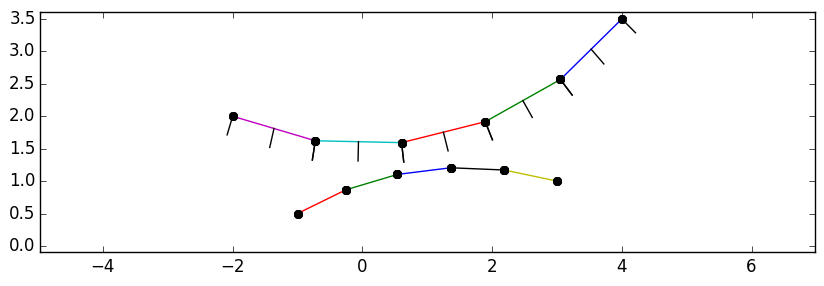

(-0.1,3.6)

In [80]:
function average_normals!(elements, time, normal_field="normal")
    d = Dict()
    # calculate sum of normals connecting to node k
    for el in elements
        c = get_connectivity(el)
        n = interpolate(el[normal_field], time).values
        for (ci, ni) in zip(c, n)
            d[ci] = haskey(d, ci) ? d[ci] + ni : ni
        end
    end
    # norm
    for (ci, ni) in d
        d[ci] /= norm(d[ci])
    end
    # update back to elements
    for el in elements
        c = get_connectivity(el)
        #new_normals = Field(time, [d[ci] for ci in c])
        #set_field(el, normal_field, new_normals)
        #el[normal_field][end].values = new_normals
        #push!(el[normal_field], new_normals)
        el[normal_field][end].values = [d[ci] for ci in c]
    end
end

average_normals!(Γ₁, 0.0)
average_normals!(Γ₂, 0.0)

figure(figsize=(10, 3))
for el in Γ₁
    plot_element(el; plot_with_normal=true)
end
for el in Γ₂
    plot_element(el; plot_with_normal=false)
end
axis("equal")
ylim(-0.1, 3.6)
#axis("off")

In [6]:
function newton(R, dR, x0=0.0; max_iterations=10, tol=1.0e-9)
    x = x0
    for i=1:max_iterations
        dx = -R(x)/dR(x)
        x += dx
        if abs(dx) < tol
            break
        end
    end
    x
end

"""
Find projection from slave nodes to master element.

Parameters
----------
sel :: Element
    slave element
mel :: Element
    master element
sxi :: Vector
    projection point in slave side (typically [-1.0] or [1.0])

Returns
-------
mxi :: Vector
    point in master element corresponding to xi in slave

"""
function calc_projection_from_slave_to_master(sel, mel, sxi; solver_options...)
    # slave side point
    X1 = interpolate(sel, :Geometry, sxi)
    N1 = interpolate(sel, :Normals, sxi)
    # master element function and their derivatives
    X2(xi) = interpolate(mel, :Geometry, xi)
    dX2(xi) = dinterpolate(mel, :Geometry, xi)
    # residual & solution
    R(xi) = det([X2(xi)-X1 N1])
    dR(xi) = det([dX2(xi) N1])
    mxi = newton(R, dR; solver_options...)
    return [mxi]
end

"""
Find projection from master to slave element.

Parameters
----------
sel :: Element
    slave element
mel :: Element
    master element
mxi :: Vector
    projection point in master side (typically [-1.0] or [1.0])

Returns
-------
sxi :: Vector
    point in slave element corresponding to xi in master
"""
function calc_projection_from_master_to_slave(sel, mel, mxi; solver_options...)
    # slave element functions and their derivatives
    X1(xi) = interpolate(sel, :Geometry, xi)
    dX1(xi) = dinterpolate(sel, :Geometry, xi)
    N1(xi) = interpolate(sel, :Normals, xi)
    dN1(xi) = dinterpolate(sel, :Normals, xi)
    # master side point
    X2 = interpolate(mel, :Geometry, mxi)
    # residual & solution
    R(xi) = det([X1(xi)-X2 N1(xi)])
    dR(xi) = det([dX1(xi) N1(xi)]) + det([X1(xi)-X2 dN1(xi)])
    sxi = newton(R, dR; solver_options...)
    return [sxi]
end

function has_projection(xi1, xi2)
    l = abs(xi1[2]-xi1[1])[1]
    return l > 1.0e-9
end

function calc_projection(sel, mel; clamp=true)
    xi1a = calc_projection_from_master_to_slave(sel, mel, [-1.0])
    xi1b = calc_projection_from_master_to_slave(sel, mel, [ 1.0])
    xi2a = calc_projection_from_slave_to_master(sel, mel, [-1.0])
    xi2b = calc_projection_from_slave_to_master(sel, mel, [ 1.0])
    xi1 = Vector[xi1a, xi1b]
    xi2 = Vector[xi2a, xi2b]
    if clamp
        clamp!(xi1, -1, 1)
        clamp!(xi2, -1, 1)
    end
    return xi1, xi2
end

calc_projection (generic function with 1 method)

Visualize results

In [7]:
function integrate_segment(sel, mel, xi1, xi2)
    nsel = get_number_of_basis_functions(sel)
    nmel = get_number_of_basis_functions(mel)
    De = zeros(nsel, nsel)
    Me = zeros(nsel, nmel)
    return De, Me
end

integrate_segment (generic function with 1 method)

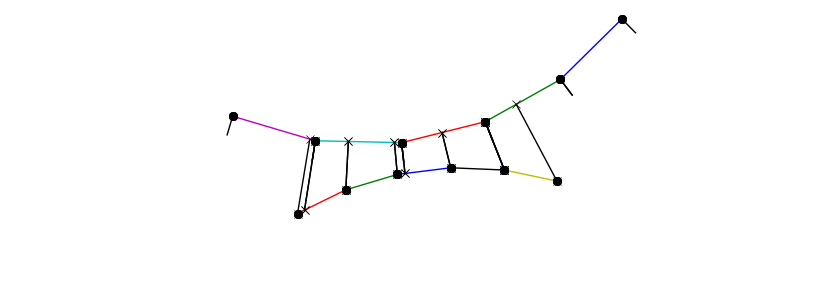

(-3.0,5.0,-0.1,3.6)

In [8]:
function plot_all()
    figure(figsize=(10, 3))
    for el in Γ₁
        plot_element(el; plot_with_normal=true)
    end
    for el in Γ₂
        plot_element(el; plot_with_normal=false)
    end
    for sel in Γ₁
        for mel in Γ₂
            xi1, xi2 = calc_projection(sel, mel)
            if has_projection(xi1, xi2)
                X1 = interpolate(sel, :Geometry, xi1)
                X2 = interpolate(mel, :Geometry, xi2)
                for s=1:2
                    x = [X1[s][1], X2[s][1]]
                    y = [X1[s][2], X2[s][2]]
                    plot(x, y, "-kx")
                end
                De, Me = integrate_segment(sel, mel, xi1, xi2)
            end
        end
    end
    axis("equal")
    ylim(-0.1, 3.6)
    axis("off")
end

plot_all()

A little experience, raise the degree of elements, smooth geometry, and test projection for 2nd order:

In [9]:
# to raise degree of elements and smooth geometry
function tangent(el, xi)
    normal = interpolate(el, :Normals, xi)
    [0 -1; 1 0]'*normal
end
for el in [Γ₁; Γ₂]
    set_degree(el, 2)
    for field in (:Geometry, :Normals)
        push!(el.fields[field], [0.0, 0.0])
        el.fields[field] = el.fields[field][1:get_number_of_basis_functions(el)]
    end
end
for el in [Γ₁; Γ₂]
    fit_derivative_field!(el, :Geometry, tangent, Int[1, 2])
end
plot_all()

LoadError: LoadError: BoundsError: attempt to access (2,)
  at index [2]
while loading In[9], in expression starting on line 13